In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install wfdb

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import wfdb
import linecache
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
!pip install ecg_plot

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import wfdb
import linecache
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
from scipy import signal
import tensorflow as tf
from tensorflow import keras
import neurokit2 as nk
import wfdb
import ecg_plot
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from collections import Counter

Data Loading

In [ ]:
data_dir = '/content/drive/MyDrive/ptbdb'
file_list = [f for f in os.listdir(data_dir) if f.endswith('.dat')]
data = []
labels = []
# Loop over all files
for f in file_list:
  record = wfdb.rdrecord(os.path.join(data_dir, f[:-4]))
  data.append(record.p_signal)
  # Load label from .hea file

In [ ]:
directory = '/content/drive/MyDrive/ptbdb/HEAFiles'
labels=[]
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    particular_line = linecache.getline(f, 23)
    
    diagnose=particular_line.split()
    disease=' '.join(diagnose[4:])
    labels.append(disease)

In [ ]:
labels

In [ ]:
np.unique(labels)

array(['Bundle branch block', 'Cardiomyopathy', 'Dysrhythmia',
       'Healthy control', 'Heart failure (NYHA 2)',
       'Heart failure (NYHA 3)', 'Heart failure (NYHA 4)', 'Hypertrophy',
       'Myocardial infarction', 'Myocarditis', 'Palpitation',
       'Stable angina', 'Unstable angina', 'Valvular heart disease',
       'n/a'], dtype='<U22')

In [ ]:
data, labels= np.array(data), np.array(labels)

In [ ]:
labels_to_delete = ['n/a','Unstable angina','Valvular heart disease','Heart failure (NYHA 2)','Palpitation','Stable angina','Heart failure (NYHA 3)','Heart failure (NYHA 4)','Hypertrophy','Myocarditis', 'Bundle branch block', 'Dysrhythmia', 'Cardiomyopathy']

In [ ]:
indices_to_delete = np.isin(labels, labels_to_delete)

In [ ]:
labels = labels[~indices_to_delete]
data = data[~indices_to_delete]

In [ ]:
data_truncated = np.array([subarray[:1000] for subarray in data])
labels_truncated = labels[:data_truncated.shape[0]]

In [ ]:
diseases=np.unique(labels_truncated)
diseases

array(['Healthy control', 'Myocardial infarction'], dtype='<U22')

In [ ]:
counts = dict()
for i in labels:
  counts[i] = counts.get(i, 0) + 1

In [ ]:
counts

{'Myocardial infarction': 368, 'Healthy control': 80}

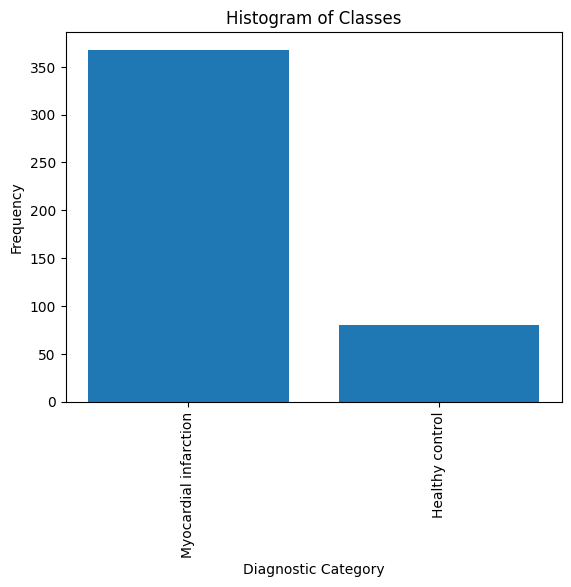

In [ ]:
label_counts = dict(Counter(labels_truncated))
plt.bar(label_counts.keys(), label_counts.values())

plt.xlabel('Diagnostic Category')
plt.xticks(rotation=90)

plt.ylabel('Frequency')
plt.title('Histogram of Classes')
plt.show()

Visual plot of how normal heartbeat looks like and how an irregular heartbeat looks like.


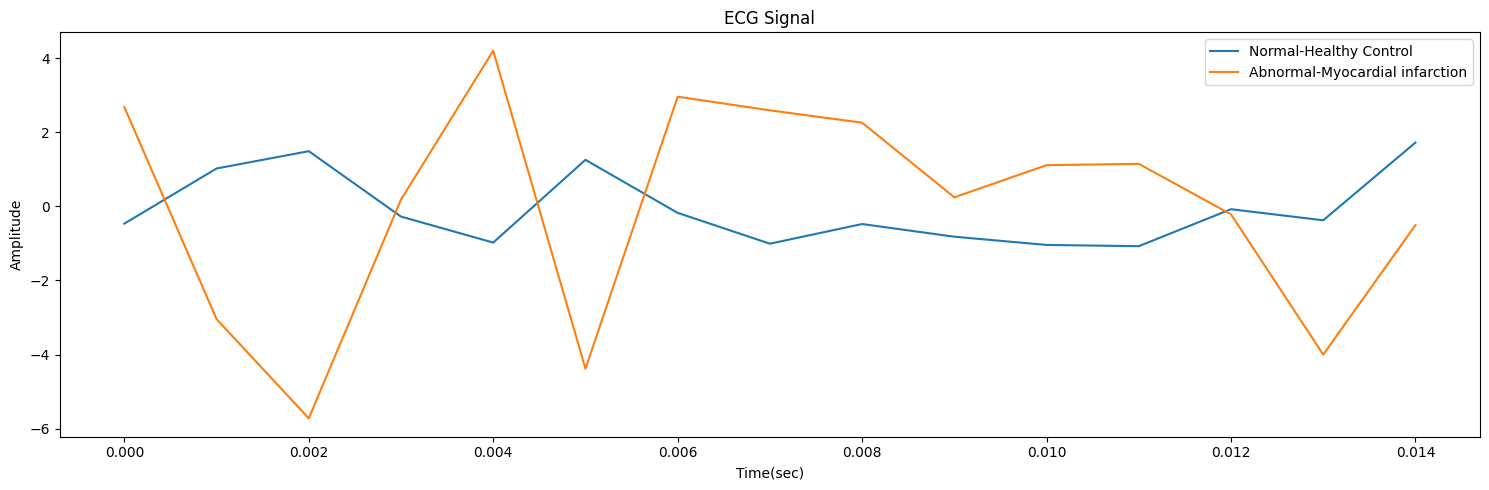

In [ ]:
print("Visual plot of how normal heartbeat looks like and how an irregular heartbeat looks like.")

x_length = 225
x=np.arange(187)/1000
plt.figure(figsize=(15,5))
plt.plot(x[:15],data_truncated[251][0].ravel(),label='Normal-Healthy Control')
plt.plot(x[:15],data_truncated[1][100].ravel(),label='Abnormal-Myocardial infarction')
plt.legend()
plt.xlabel('Time(sec)')
plt.ylabel("Amplitude")
plt.title("ECG Signal")
plt.tight_layout()
plt.show()

In [ ]:
normalized_data = []
for record in data_truncated:
    mean = np.mean(record)
    std = np.std(record)        
    normalized_record = (record - mean) / std
    normalized_data.append(normalized_record)
data = np.array(normalized_data)
diseases_dict={k: v for v, k in enumerate(diseases)}

labels = [diseases_dict[label] for label in labels]


In [ ]:
len(data)

448

In [ ]:
len(labels)

448

In [ ]:
print(data.shape)

(448, 1000, 15)


Train_Test_Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test=np.array(X_train),np.array(X_test) ,np.array(y_train),np.array(y_test)  

In [ ]:
X_train, X_val, y_train, y_val = np.array(X_train),np.array(X_val) ,np.array(y_train),np.array(y_val) 

In [ ]:
X_train.shape

(286, 1000, 15)

In [ ]:
X_test.shape

(90, 1000, 15)

In [ ]:
y_train.shape

(286,)

In [ ]:
y_test.shape

(90,)

In [ ]:
X_val.shape

(72, 1000, 15)

In [ ]:
y_val.shape

(72,)

In [ ]:
len(np.unique(labels))

2

CNN_LSTM with Attention mechanism

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Activation, Permute, multiply
from tensorflow.keras.utils import to_categorical

# Define the input shape
input_shape = (1000, 15)  # Variable-length input, 12 leads

# Define the number of classes
num_classes = len(set(y_train))

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Define the model
input_layer = Input(shape=input_shape)

# Convolutional layers
conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(conv)
conv = MaxPooling1D(pool_size=2)(conv)

conv = Conv1D(128, kernel_size=3, activation='relu', padding='same')(conv)
conv = Conv1D(128, kernel_size=3, activation='relu', padding='same')(conv)
conv = MaxPooling1D(pool_size=2)(conv)

conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv)
conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv)
conv = MaxPooling1D(pool_size=2)(conv)

conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv)
conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv)
conv = MaxPooling1D(pool_size=2)(conv)

conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv)
conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv)
conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv)
conv = MaxPooling1D(pool_size=2)(conv)

# Permute layer for attention mechanism
conv = Permute((2, 1))(conv)

# LSTM layers
lstm = LSTM(128, return_sequences=True)(conv)
lstm = LSTM(128)(lstm)

# Attention mechanism
attention = Dense(128, activation='softmax')(lstm)
attention = multiply([lstm, attention])

# Classifier
output = Dense(num_classes, activation='softmax')(attention)

# Create the CNN-LSTM model
CNN_LSTM_model = Model(inputs=input_layer, outputs=output)

# Compile the model
CNN_LSTM_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
CNN_LSTM_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1000, 15)]   0           []                               
                                                                                                  
 conv1d_141 (Conv1D)            (None, 1000, 64)     2944        ['input_21[0][0]']               
                                                                                                  
 conv1d_142 (Conv1D)            (None, 1000, 64)     12352       ['conv1d_141[0][0]']             
                                                                                                  
 max_pooling1d_84 (MaxPooling1D  (None, 500, 64)     0           ['conv1d_142[0][0]']             
 )                                                                                         

In [ ]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
CNN_LSTM_history = CNN_LSTM_model.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping])


# Evaluate on test set
y_pred = CNN_LSTM_model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

test_loss = CNN_LSTM_model.evaluate(X_test, y_test_one_hot)[0]
test_acc = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)
precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)
recall = recall_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)

print('Test accuracy:', test_acc)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Epoch 1/20
9/9 [==============================] - 10s 187ms/step - loss: 0.6901 - accuracy: 0.7517 - val_loss: 0.6792 - val_accuracy: 0.8750
Epoch 2/20
9/9 [==============================] - 0s 53ms/step - loss: 0.6617 - accuracy: 0.8042 - val_loss: 0.6217 - val_accuracy: 0.8750
Epoch 3/20
9/9 [==============================] - 0s 50ms/step - loss: 0.6102 - accuracy: 0.8042 - val_loss: 0.5565 - val_accuracy: 0.8750
Epoch 4/20
9/9 [==============================] - 0s 52ms/step - loss: 0.5790 - accuracy: 0.8042 - val_loss: 0.5345 - val_accuracy: 0.8750
Epoch 5/20
9/9 [==============================] - 0s 49ms/step - loss: 0.5666 - accuracy: 0.8042 - val_loss: 0.5236 - val_accuracy: 0.8750
Epoch 6/20
9/9 [==============================] - 0s 50ms/step - loss: 0.5597 - accuracy: 0.8042 - val_loss: 0.5145 - val_accuracy: 0.8750
Epoch 7/20
9/9 [==============================] - 0s 51ms/step - loss: 0.5537 - accuracy: 0.8042 - val_loss: 0.5062 - val_accuracy: 0.8750
Epoch 8/20
9/9 [=========

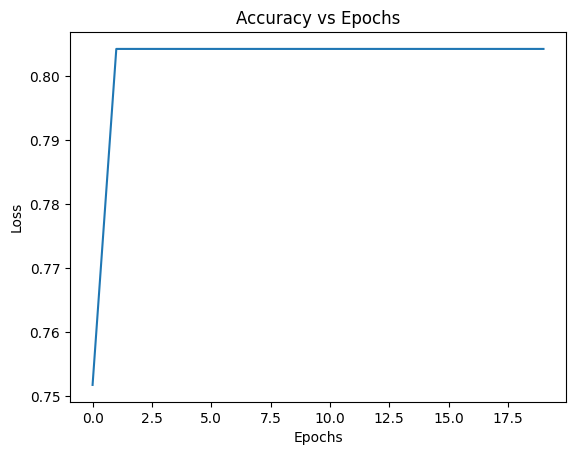

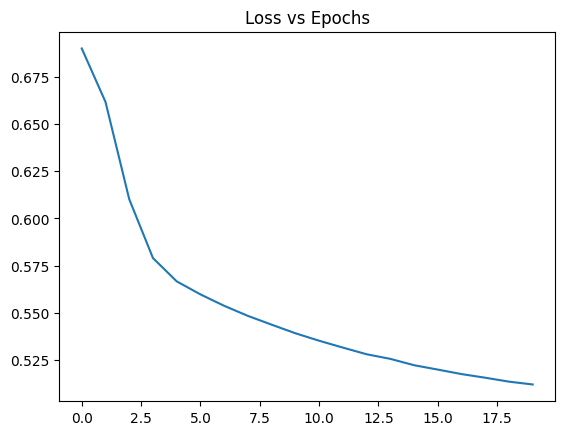

In [ ]:
frame = pd.DataFrame(CNN_LSTM_history.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")

CNN_Transformer 

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

# Define the input shape
input_shape = (1000, 15)  # Variable-length input, 12 leads

# Define the number of classes
num_classes = len(set(y_train))

# Define the CNN-Transformer model
def cnn_transformer_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters=32, kernel_size=30, activation='relu')(input_layer)
    pooling1 = MaxPooling1D(pool_size=2)(conv1)
    bn1 = BatchNormalization()(pooling1)
    dropout1 = Dropout(0.2)(bn1)

    conv2 = Conv1D(filters=6, kernel_size=10, activation='relu')(dropout1)
    pooling2 = MaxPooling1D(pool_size=2)(conv2)
    bn2 = BatchNormalization()(pooling2)
    dropout2 = Dropout(0.2)(bn2)

    conv3 = Conv1D(filters=64, kernel_size=10, activation='relu')(dropout2)
    pooling3 = MaxPooling1D(pool_size=2)(conv3)
    bn3 = BatchNormalization()(pooling3)
    dropout3 = Dropout(0.2)(bn3)

    conv4 = Conv1D(filters=128, kernel_size=5, activation='relu')(dropout3)
    pooling4 = MaxPooling1D(pool_size=2)(conv4)
    bn4 = BatchNormalization()(pooling4)
    dropout4 = Dropout(0.2)(bn4)

    conv5 = Conv1D(filters=128, kernel_size=5, activation='relu')(dropout4)
    pooling5 = MaxPooling1D(pool_size=2)(conv5)
    bn5 = BatchNormalization()(pooling5)
    dropout5 = Dropout(0.2)(bn5)

    conv6 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout5)
    pooling6 = MaxPooling1D(pool_size=2)(conv6)
    bn6 = BatchNormalization()(pooling6)
    dropout6 = Dropout(0.2)(bn6)

    conv7 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout6)
    pooling7 = MaxPooling1D(pool_size=2)(conv7)
    bn7 = BatchNormalization()(pooling7)
    dropout7 = Dropout(0.2)(bn7)

   # Transformer layers (Self-Attention)
    transformer_layer = dropout7
    for _ in range(3):  # Increase the number of transformer layers to 3
        transformer_layer = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.2)(transformer_layer, transformer_layer)

    # Flatten the output
    flatten = Flatten()(transformer_layer)

    # Dense layers
    dense1 = Dense(256, activation='relu')(flatten)
    bn8 = BatchNormalization()(dense1)
    dropout8 = Dropout(0.2)(bn8)
    
    output = Dense(num_classes, activation='softmax')(dropout8)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Create the CNN-Transformer-LSTM model
CNN_Transformer_model = cnn_transformer_model(input_shape=(1000, 15), num_classes=num_classes)

# Compile the model
CNN_Transformer_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
CNN_Transformer_model.summary()


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1000, 15)]   0           []                               
                                                                                                  
 conv1d_155 (Conv1D)            (None, 971, 32)      14432       ['input_23[0][0]']               
                                                                                                  
 max_pooling1d_92 (MaxPooling1D  (None, 485, 32)     0           ['conv1d_155[0][0]']             
 )                                                                                                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 485, 32)     128         ['max_pooling1d_92[0][0]']

In [ ]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
CNN_Transformer_history = CNN_Transformer_model.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping])


# Evaluate on test set
y_pred = CNN_Transformer_model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

test_loss = CNN_Transformer_model.evaluate(X_test, y_test_one_hot)[0]
test_acc = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)
precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)
recall = recall_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)

print('Test accuracy:', test_acc)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Epoch 1/20
9/9 [==============================] - 13s 94ms/step - loss: 0.6877 - accuracy: 0.5455 - val_loss: 0.6477 - val_accuracy: 0.8750
Epoch 2/20
9/9 [==============================] - 0s 30ms/step - loss: 0.6610 - accuracy: 0.6364 - val_loss: 0.5989 - val_accuracy: 0.8750
Epoch 3/20
9/9 [==============================] - 0s 31ms/step - loss: 0.6052 - accuracy: 0.7063 - val_loss: 0.5580 - val_accuracy: 0.8750
Epoch 4/20
9/9 [==============================] - 0s 31ms/step - loss: 0.6057 - accuracy: 0.7133 - val_loss: 0.5209 - val_accuracy: 0.8750
Epoch 5/20
9/9 [==============================] - 0s 29ms/step - loss: 0.5573 - accuracy: 0.7448 - val_loss: 0.4838 - val_accuracy: 0.8750
Epoch 6/20
9/9 [==============================] - 0s 29ms/step - loss: 0.5314 - accuracy: 0.7867 - val_loss: 0.4542 - val_accuracy: 0.8750
Epoch 7/20
9/9 [==============================] - 0s 32ms/step - loss: 0.4954 - accuracy: 0.7937 - val_loss: 0.4335 - val_accuracy: 0.8750
Epoch 8/20
9/9 [==========

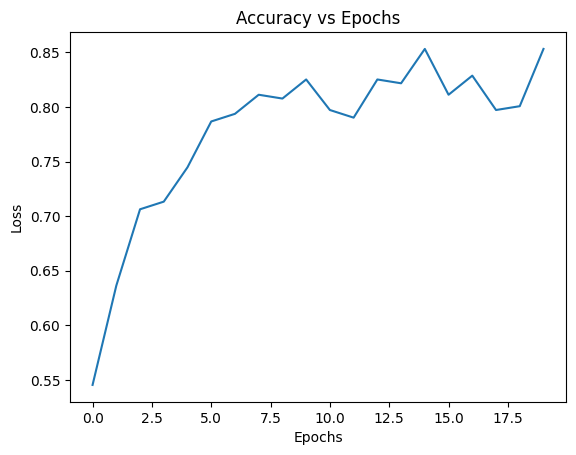

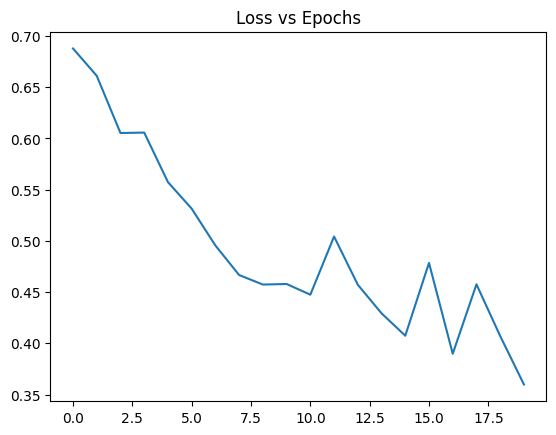

In [ ]:
frame = pd.DataFrame(CNN_Transformer_history.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")

CNN_Transformer_LSTM 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Add, Activation

# Define the number of classes
num_classes = 2

# Define the CNN-Transformer-LSTM model
def cnn_transformer_lstm_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
    conv2 = Conv1D(filters=32, kernel_size=5, activation='relu')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv2)

    # Transformer layers
    attention = MultiHeadAttention(num_heads=4, key_dim=32)(pool1, pool1, pool1)
    add1 = Add()([pool1, attention])
    normalize1 = LayerNormalization(epsilon=1e-6)(add1)

    # Residual connection
    residual1 = Add()([pool1, normalize1])

    # LSTM layer
    lstm1 = LSTM(units=64, return_sequences=True)(residual1)
    lstm2 = LSTM(units=64, return_sequences=False)(lstm1)

    # Dense layer
    flatten = Flatten()(lstm2)
    dense1 = Dense(units=64, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)

    # Output layer
    outputs = Dense(units=num_classes, activation='softmax')(dropout)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the CNN-Transformer-LSTM model
CNN_LSTM_Transformer_Residual_model = cnn_transformer_lstm_model(input_shape=(1000, 15), num_classes=num_classes)

# Compile the model
CNN_LSTM_Transformer_Residual_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
CNN_LSTM_Transformer_Residual_model.summary()


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1000, 15)]   0           []                               
                                                                                                  
 conv1d_164 (Conv1D)            (None, 996, 32)      2432        ['input_25[0][0]']               
                                                                                                  
 conv1d_165 (Conv1D)            (None, 992, 32)      5152        ['conv1d_164[0][0]']             
                                                                                                  
 max_pooling1d_100 (MaxPooling1  (None, 496, 32)     0           ['conv1d_165[0][0]']             
 D)                                                                                        

In [ ]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
CNN_LSTM_Transformer_Residual_history = CNN_LSTM_Transformer_Residual_model.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping])


# Evaluate on test set
y_pred = CNN_LSTM_Transformer_Residual_model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

test_loss = CNN_LSTM_Transformer_Residual_model.evaluate(X_test, y_test_one_hot)[0]
test_acc = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)
precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)
recall = recall_score(y_test, y_pred_labels, average='weighted', zero_division=1.0)

print('Test accuracy:', test_acc)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Epoch 1/20
9/9 [==============================] - 10s 199ms/step - loss: 0.5929 - accuracy: 0.7413 - val_loss: 0.4232 - val_accuracy: 0.8750
Epoch 2/20
9/9 [==============================] - 1s 67ms/step - loss: 0.4872 - accuracy: 0.8042 - val_loss: 0.4120 - val_accuracy: 0.8750
Epoch 3/20
9/9 [==============================] - 1s 75ms/step - loss: 0.4767 - accuracy: 0.8042 - val_loss: 0.4321 - val_accuracy: 0.8750
Epoch 4/20
9/9 [==============================] - 1s 65ms/step - loss: 0.4723 - accuracy: 0.8077 - val_loss: 0.4108 - val_accuracy: 0.8750
Epoch 5/20
9/9 [==============================] - 1s 64ms/step - loss: 0.4253 - accuracy: 0.8147 - val_loss: 0.4093 - val_accuracy: 0.8750
Epoch 6/20
9/9 [==============================] - 1s 64ms/step - loss: 0.4024 - accuracy: 0.8427 - val_loss: 0.4603 - val_accuracy: 0.7917
Epoch 7/20
9/9 [==============================] - 1s 63ms/step - loss: 0.3927 - accuracy: 0.8462 - val_loss: 0.4529 - val_accuracy: 0.8056
Epoch 8/20
9/9 [=========

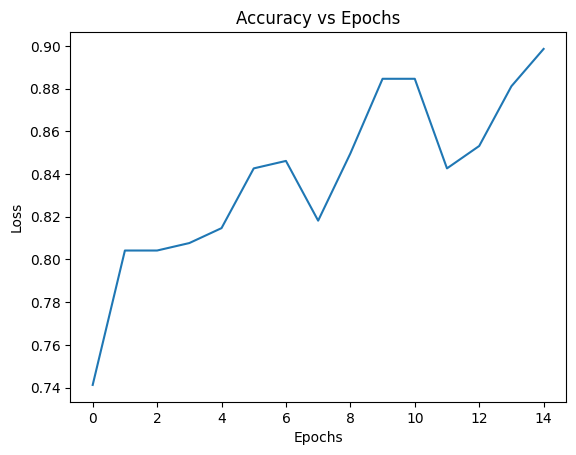

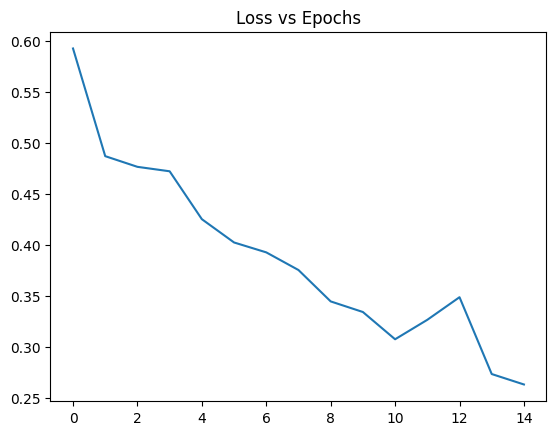

In [ ]:
frame = pd.DataFrame(CNN_LSTM_Transformer_Residual_history.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plt = acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

loss_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
loss_plt = acc_plot.set(xlabel="Epochs", ylabel="Loss")